In [1]:
import cpm
from packaging import version

## cpm checks
print(cpm.__version__)
if version.parse(cpm.__version__) < version.parse("0.22"):
    raise ImportError("cpm version must be >= 0.22. Please install the latest version using: pip install --upgrade cpm")

0.23.1


# EXERCISE 3

In this exercise, you will use the model you implemented in Exercise 1 to fit some real-world data. Then you will repeat the same process with a hierarchical modeling approach.

## EXERCISE 3.1: Import the data and your model from Exercise 1

In [2]:
import numpy
import pandas as pd
import cpm
import cpm.datasets as datasets
from cpm.generators import Parameters, Value
import ipyparallel as ipp  # for parallel computing with ipython (specific for Jupyter Notebook)

data = datasets.load_bandit_data()
data.head()

parameters = Parameters(
    # free parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args={"mean": 0.5, "sd": 0.25},
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
        args={"mean": 5, "sd": 2.5},
    ),
    # everything without a prior is part of the initial state of the
    # model or constructs fixed throughout the simulation
    # (e.g. exemplars in general-context models of categorizations)
    # initial q-values starting starting from non-zero value
    # these are equal to all 4 stimuli (1 / 4)
    values = numpy.array([0.25, 0.25, 0.25, 0.25])
    )

@ipp.require("numpy")
def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = numpy.array(parameters.values)
    
    # pull out the trial information
    stimulus = numpy.array([trial.arm_left, trial.arm_right]).astype(int)
    feedback = numpy.array([trial.reward_left, trial.reward_right])
    human_choice = trial.response.astype(int)

    # Equation 1. - get the value of each available action
    # Note that because python counts from 0, we need to shift
    # the stimulus identifiers by -1
    expected_rewards = values[stimulus - 1]
    # convert columns to rows
    expected_rewards = expected_rewards.reshape(2, 1)
    # calculate a policy based on the activations
    # Equation 2.
    choice_rule = cpm.models.decision.Softmax(
        activations=expected_rewards,
        temperature=temperature
        )
    choice_rule.compute() # compute the policy
    # if the policy is NaN for an action, then we need to set it to 1
    # this corrects some numerical issues with python and infinities
    if numpy.isnan(choice_rule.policies).any():
        choice_rule.policies[numpy.isnan(choice_rule.policies)] = 1
    # get the received reward for the choice
    reward = feedback[human_choice]
    teacher = numpy.array([reward])
    # we now create a vector that tells our learning rule what...
    # ... stimulus to update according to the participant's choice
    what_to_update = numpy.zeros(4)
    chosen_stimulus = stimulus[human_choice] - 1
    what_to_update[chosen_stimulus] = 1

    # Equation 4.
    update = cpm.models.learning.SeparableRule(
                    weights=values,
                    feedback=teacher,
                    input=what_to_update,
                    alpha=alpha
                    )
    update.compute()
    # Equation 5.
    values += update.weights.flatten()
    # compile output
    output = {
        "trial"    : trial.trial.astype(int), # trial numbers
        "activation" : expected_rewards.flatten(), # expected reward of arms
        "policy"   : choice_rule.policies,       # policies
        "reward"   : reward,                  # received reward
        "error"    : update.weights,          # prediction error
        "values"   : values,                  # updated values
        # dependent variable
        "dependent"  : numpy.array([choice_rule.policies[1]]),
    }
    return output

generative_model = cpm.generators.Wrapper(
    model=model,
    parameters=parameters,
    data=data[data == 1],
)

## EXERCISE 3.2: Fit the model to the data


### EXERCISE 3.2.1: Specify your discrepency function

Compared to the previous exercise, I would like you to spend some more time with discrepency (loss) functions.
Here, you will write your own. There is no need to stick with log-likelihood, you can use any discrepency function you like.

Here is a reminder of the loss function we used in Exercise 2:

\begin{align*}
-\log L(\theta \mid Y, M) = -\sum_{i=1}^{N} \log \bigg[ p(y_i \mid \theta) \bigg]
\end{align*}

where $\theta$ are model parameters, $Y$ is the data (`observed` in the code) with $N$ number of data points, and $M$ is the model. The $p(y~|~\theta)$ gives the probability of observing the data given a certain parameter set. It follows a _Bernoulli_ distribution and defined such as:


\begin{align*}
p(y_t~|~\theta) = \left\{ \begin{array}{ll} P(a_t) &
\text{if } y = 1, \text{ and} \\ 1 - P(a_t) & \text{if } y = 0.
\end{array} \right.
\end{align*}

where $t$ stands for time, and $P(a_t)$ is the probability of an action at time $t$.

**Please write. your own discrepency function below:**

In [ ]:
def my_discrepency_function(observed, predicted):
        __________________________________________
        return _____

### EXERCISE 3.2.3: Fit the model

Similarly to how we did in Exercise 2, you will specify the `observed` variable in the data, then use `FminBound` to fit the model to the data.**Please fill in the missing parts!**


In [ ]:
from cpm.optimisation import minimise, FminBound

data["observed"] = data["response"].astype(int)  # convert response to int

# Set up the fitting procedure
fit = FminBound(
    model=_________________,  # Wrapper class with the model we specified from before
    data=_________________,  # the data as a list of dictionaries
    minimisation=_________________,
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    prior=False,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit.optimise()

Starting optimization 1/5 from [0.94447141 8.07036527]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 10/10 [00:04<00:00,  2.07engine/s]
Starting optimization 2/5 from [0.9053863  2.88717113]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 10/10 [00:04<00:00,  2.07engine/s]
Starting optimization 3/5 from [0.45781987 4.73761662]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 10/10 [00:04<00:00,  2.04engine/s]
Starting optimization 4/5 from [0.73137905 0.56824462]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 10/10 [00:04<00:00,  2.04engine/s]
Starting optimization 5/5 from [0.68333384 9.7095275 ]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 10/10 [00:04<00:00,  2.07engine/s]


<Axes: >

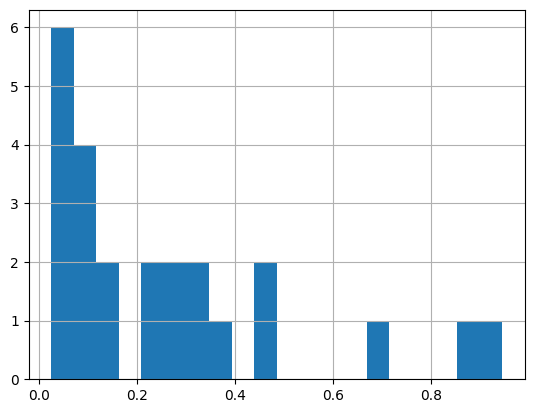

In [ ]:
parameter_estimates_non_hierarchical = fit.export()
parameter_estimates_non_hierarchical.rename(
    columns={
        "x_0": "alpha",
        "x_1": "temperature",
    },
    inplace=True
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

parameter_estimates_non_hierarchical.alpha.hist(bins=20, ax=axs[0])
parameter_estimates_non_hierarchical.temperature.hist(bins=20,  ax=axs[1])

plt.show()

- What do you notice about the results of the parameter estimation?
- How well do you think people are doing in the task based on only the parameter estimates?

## EXERCISE 3.3: Hierarchical modeling

Now, how do we turn our model into a hierarchical model? The idea is to assume that the parameters of the model are not fixed, but rather drawn from a distribution. The variance between subject-level parameters are constrained through the priors drawn over the parameter space. But, hey! We have already defined the priors in Exercise 1, so we can just use those. The way to use them is to flip a switch in the optimisation function.

In [ ]:
from cpm.optimisation import minimise, FminBound

data["observed"] = data["response"].astype(int)  # convert response to int

# Set up the fitting procedure
fit = FminBound(
    model=_________________,  # Wrapper class with the model we specified from before
    data=_________________,  # the data as a list of dictionaries
    minimisation=_________________,
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    prior=_________,  # !!! use priors for the parameters
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit.optimise()

Starting optimization 1/5 from [0.21848404 5.01040771]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 5/5 [00:05<00:00,  1.12s/engine]
Starting optimization 2/5 from [0.19980709 7.13409006]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 5/5 [00:05<00:00,  1.09s/engine]
Starting optimization 3/5 from [0.86748142 7.82568334]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 5/5 [00:05<00:00,  1.09s/engine]
Starting optimization 4/5 from [0.77049691 4.5041182 ]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 5/5 [00:05<00:00,  1.09s/engine]
Starting optimization 5/5 from [0.1533961  5.07668576]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
100%|██████████| 5/5 [00:05<00:00,  1.09s/engine]


In [ ]:
parameter_estimates_with_hierarchical = fit.export()
parameter_estimates_with_hierarchical.rename(
    columns={
        "x_0": "alpha",
        "x_1": "temperature",
    },
    inplace=True
)

## Plot the results just as before
_________________________________

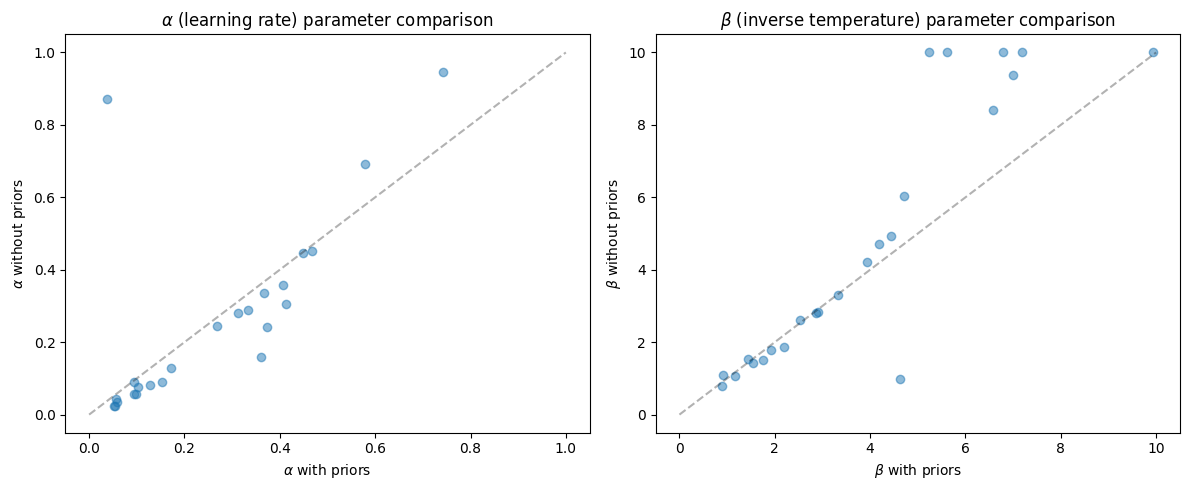

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(
    parameter_estimates_with_hierarchical.alpha,
    parameter_estimates_non_hierarchical.alpha,
    "o",
    alpha=0.5,
    label="Non-hierarchical"
)
ax[0].set_ylabel(r"$\alpha$ without priors")
ax[0].set_xlabel(r"$\alpha$ with priors")
ax[0].set_title(r"$\alpha$ (learning rate) parameter comparison")
ax[0].plot([0, 1], [0, 1], "k--", alpha=0.3)  # reference line

ax[1].plot(
    parameter_estimates_with_hierarchical.temperature,
    parameter_estimates_non_hierarchical.temperature,
    "o",
    alpha=0.5,
    label="Non-hierarchical"
)
ax[1].set_ylabel(r"$\beta$ without priors")
ax[1].set_xlabel(r"$\beta$ with priors")
ax[1].set_title(r"$\beta$ (inverse temperature) parameter comparison")
ax[1].plot([0, 10], [0, 10], "k--", alpha=0.3)  # reference line

plt.tight_layout()
plt.show()

# Questions

- What is the difference between the model you fitted in Exercise 2 and the one you will fit here?
- What did you learn about the impact of priors on parameter estimation?
- What differences you notice between the results of the two parameter estimations? Is it better, worse, or the something else?
- In what situations would you prefer a hierarchical model over a non-hierarchical one?
- How confident are you in the parameter estimates, and what could increase your confidence?